# Solutions for Assignment 5: Web Scraping and Big Data

**NOTE: THIS ASSIGNMENT IS OPTIONAL**

You must complete one out of homeworks #4, #5, and #6.

**Due date: Monday, 11/14 by the end of the day**

The notebook should be submitted to your own private repository on GitHub, which can be created using the following link:

https://classroom.github.com/a/JQOH_Yf-


### Part 1: Scraping Craigslist

In this section, you will use Selenium and BeautifulSoup to scrape data for hundreds of apartments from Philadelphia's Craigslist portal.

### Part 2: Exploring a "large" dataset of your choice

In this section, you'll use datashader to create an animated timelapse of a "large" dataset of your choice.

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## Part 1: Scraping Craigslist

In this part, we'll be extracting information on apartments from Craigslist search results. You'll be using Selenium and BeautifulSoup to extract the relevant information from the HTML text. 

For reference on CSS selectors, please see the [notes from Week 6](https://github.com/MUSA-550-Fall-2022/week-6/blob/main/css-selectors.md).

### Primer: the Craigslist website URL

We'll start with the Philadelphia region. First we need to figure out how to submit a query to Craigslist. As with many websites, one way you can do this is simply by constructing the proper URL and sending it to Craigslist. 

https://philadelphia.craigslist.org/search/apa?min_price=1&min_bedrooms=1&minSqft=1#search=1~gallery~0~0

There are **three** components to this URL. 

1. The base URL: `http://philadelphia.craigslist.org/search/apa`

2. The user's search parameters: `?min_price=1&min_bedrooms=1&minSqft=1`

> We will send nonzero defaults for some parameters (bedrooms, size, price) in order to exclude results that have empty values for these parameters.


3. The URL *hash*: `#search=1~gallery~0~0`

> As we will see later, this part will be important because it contains the search page result number.


The Craigslist website requires Javascript, so we'll need to use Selenium to load the page, and then use BeautifulSoup to extract the information we want. 



## 1.1 Initialize a selenium driver and open Craigslist

As discussed in lecture, you can use Chrome, Firefox, or Edge as your selenium driver. In this part, you should do two things:

1. Initialize the selenium driver
1. Use the `driver.get()` function to open the following URL:

https://philadelphia.craigslist.org/search/apa?min_price=1&min_bedrooms=1&minSqft=1#search=1~gallery~0~0

This will give you the search results for 1-bedroom apartments in Philadelphia.


In [5]:
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.chrome.service import Service
from selenium import webdriver

In [6]:
driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()))

In [7]:
url = "https://philadelphia.craigslist.org/search/apa?min_price=1&min_bedrooms=1&minSqft=1#search=1~gallery~0~0"

In [8]:
driver.get(url)

## 1.2 Initialize your "soup"

Once selenium has the page open, we can get the page source from the driver and use BeautifulSoup to parse it. In this part, initialize a BeautifulSoup object with the driver's page source



In [9]:
from bs4 import BeautifulSoup

In [10]:
soup = BeautifulSoup(driver.page_source, "html.parser")

## 1.3 Parsing the HTML

Now that we have our "soup" object, we can use BeautifulSoup to extract out the elements we need:

- Use the Web Inspector to identify the HTML element that holds the information on each apartment listing.
- Use BeautifulSoup to extract these elements from the HTML. 


At the end of this part, you should have a list of 120 elements, where each element is the listing for a specific apartment on the search page.

In [11]:
apts = soup.select(".cl-search-result")
print(len(apts))

120


## 1.4 Find the relevant pieces of information

We will now focus on the **first element** in the list of 120 apartments. Use the `prettify()` function to print out the HTML for this first element. 

From this HTML, identify the HTML elements that hold:

- The apartment price
- The number of bedrooms
- The square footage
- The apartment title
- The datetime string of the posting, e.g., '2019-03-23 12:07'

For the first apartment, print out each of these pieces of information, using BeautifulSoup to select the proper elements.

**Hints**
- Each of these can be extracted using the `text` attribute of the selected element object, except for the datetime string. This information is stored as an *attribute* of an HTML element and is not part of the displayed text on the webpage

In [12]:
first_apt = apts[0]
print(first_apt.prettify())

<li class="cl-search-result cl-search-view-mode-gallery" title="Hardwood Floors, 24/7 Gym, Breakfast Bar, W/D, PETS">
 <div class="gallery-card">
  <div class="cl-result-info" title="Hardwood Floors, 24/7 Gym, Breakfast Bar, W/D, PETS">
   <div class="supertitle">
    Near Wynnewood and Narberth Station
   </div>
   <div class="title-blob">
    <button class="bd-button cl-favorite-button icon-only" tabindex="0" title="add to favorites list" type="button">
     <span class="icon icom-">
     </span>
     <span class="label">
     </span>
    </button>
    <a class="titlestring" href="https://philadelphia.craigslist.org/apa/7553188674.html">
     Hardwood Floors, 24/7 Gym, Breakfast Bar, W/D, PETS
    </a>
   </div>
   <div class="meta">
    <span class="when">
     <span title="Sat Nov 12 2022 10:13:16 GMT-0500 (Eastern Standard Time)">
      10 minutes ago
     </span>
    </span>
    <span class="separator">
     ·
    </span>
    <span class="priceinfo">
     $1,930
    </span>
    <

In [14]:
apt_price = first_apt.select_one(".priceinfo").text
print(apt_price)

$1,930


In [15]:
bedrooms = first_apt.select_one(".post-bedrooms").text
print(bedrooms)

1br


In [16]:
size = first_apt.select_one(".post-sqft").text
print(size)

663ft2


In [26]:
datetime = first_apt.select_one(".when span")['title']
print(datetime)

Sat Nov 12 2022 10:13:16 GMT-0500 (Eastern Standard Time)


In [28]:
title = first_apt.select_one(".titlestring").text
print(title)

Hardwood Floors, 24/7 Gym, Breakfast Bar, W/D, PETS


## 1.5 Functions to format the results 

In this section, you'll create functions that take in the raw string elements for price, size, time, and number of bedrooms and returns them formatted as numbers.

I've started the functions to format the values. You should finish theses functions in this section.

**Hints**
- You can use string formatting functions like `string.replace()` and `string.strip()`
- The `int()` and `float()` functions can convert strings to numbers

In [29]:
def format_bedrooms(bedrooms_string):
    # Format the bedrooms string and return an int
    # 
    # This will involve using the string.replace() function to 
    # remove unwanted characters
    
    return int(bedrooms_string.replace("br", ""))

In [30]:
format_bedrooms(bedrooms)

1

In [31]:
def format_size(size_string):
    # Format the size string and return a float
    # 
    # This will involve using the string.replace() function to 
    # remove unwanted characters
    
    return float(size_string.replace("ft2", ""))

In [32]:
format_size(size)

663.0

In [33]:
def format_price(price_string):
    # Format the price string and return a float
    # 
    # This will involve using the string.strip() function to 
    # remove unwanted characters
    return float(price_string.strip("$").replace(",", ""))

In [34]:
format_price(apt_price)

1930.0

In [43]:
def format_time(date_string):
    # Return a Datetime object from the datetime string
    
    i = date_string.index('(')
    date_string = date_string[0:i]
    return  pd.to_datetime(date_string)

In [44]:
format_time(datetime)

Timestamp('2022-11-12 10:13:16+0500', tz='pytz.FixedOffset(300)')

## 1.6 Putting it all together

In this part, you'll complete the code block below using results from previous parts. The code will loop over 5 pages of search results and scrape data for 600 apartments. 

We can get a specific page by changing the `search=PAGE` part of the URL hash. For example, to get page 2 instead of page 1, we will navigate to:


https://philadelphia.craigslist.org/search/apa?min_price=1&min_bedrooms=1&minSqft=1#search=2~gallery~0~0

In the code below, the outer for loop will loop over 5 pages of search results. The inner for loop will loop over the 120 apartments listed on each search page.

Fill in the missing pieces of the inner loop using the code from the previous section. We will be able to extract out the relevant pieces of info for each apartment. 

After filling in the missing pieces and executing the code cell, you should have a Data Frame called `results` that holds the data for 600 apartment listings.

#### Notes

Be careful if you try to scrape more listings. Craigslist will temporarily ban your IP address (for a very short time) if you scrape too much at once. I've added a `sleep()` function to the for loop to wait 30 seconds between scraping requests.

If the for loop gets stuck at the "Processing page X..." step for more than a minute or so, your IP address is probably banned temporarily, and you'll have to wait a few minutes before trying again.

In [45]:
from time import sleep

In [46]:
results = []

# search in batches of 120 for 5 pages
# NOTE: you will get temporarily banned if running more than ~5 pages or so
# the API limits are more leninient during off-peak times, and you can try
# experimenting with more pages
max_pages = 5

# The base URL we will be using
base_url = "https://philadelphia.craigslist.org/search/apa?min_price=1&min_bedrooms=1&minSqft=1"

# loop over each page of search results
for page_num in range(1, max_pages + 1):
    print(f"Processing page {page_num}...")

    # Update the URL hash for this page number and make the combined URL
    url_hash = f"#search={page_num}~gallery~0~0"
    url = base_url + url_hash

    # Go to the driver and wait for 5 seconds
    driver.get(url)
    sleep(5)

    # YOUR CODE: get the list of all apartments
    # This is the same code from Part 1.2 and 1.3
    # It should be a list of 120 apartments
    soup = BeautifulSoup(driver.page_source, "html.parser")
    apts = soup.select(".cl-search-result")
    print("Number of apartments = ", len(apts))

    # loop over each apartment in the list
    page_results = []
    for apt in apts:

        # YOUR CODE: the bedrooms string
        bedrooms = apt.select_one(".post-bedrooms").text

        # YOUR CODE: the size string
        size = apt.select_one(".post-sqft").text

        # YOUR CODE: the title string
        title = apt.select_one(".titlestring").text

        # YOUR CODE: the price string
        price = apt.select_one(".priceinfo").text

        # YOUR CODE: the time string
        dtime = apt.select_one(".when span")["title"]

        # YOUR CODE: Format using functions from Part 1.5
        bedrooms = format_bedrooms(bedrooms)
        size = format_size(size)
        price = format_price(price)
        dtime = format_time(dtime)

        # save the result
        page_results.append([dtime, price, size, bedrooms, title])

    # Create a dataframe and save
    col_names = ["time", "price", "size", "bedrooms", "title"]
    df = pd.DataFrame(page_results, columns=col_names)
    results.append(df)

    print("sleeping for 10 seconds between calls")
    sleep(10)

# Finally, concatenate all the results
results = pd.concat(results, axis=0).reset_index(drop=True)

Processing page 1...
Number of apartments =  120
sleeping for 10 seconds between calls
Processing page 2...
Number of apartments =  120
sleeping for 10 seconds between calls
Processing page 3...
Number of apartments =  120
sleeping for 10 seconds between calls
Processing page 4...
Number of apartments =  120
sleeping for 10 seconds between calls
Processing page 5...
Number of apartments =  120
sleeping for 10 seconds between calls


In [47]:
results.head()

,time,price,size,bedrooms,title
0,2022-11-12 10:13:16+05:00,1930.0,663.0,1,"Hardwood Floors, 24/7 Gym, Breakfast Bar, W/D,..."
1,2022-11-12 10:08:16+05:00,3190.0,1422.0,3,"Wonderful 2 bedroom, 2.5 bath, two-story Penth..."
2,2022-11-12 10:08:09+05:00,2200.0,750.0,2,Immaculate 2 Bed/1 Bath Apt Featuring a Bright...
3,2022-11-12 10:08:08+05:00,3220.0,2002.0,3,"Pickle Ball Courts, Tennis"
4,2022-11-12 10:07:12+05:00,4000.0,1900.0,2,Welcome to the carriage house of Hamilton Hall !!


In [48]:
results = results.dropna(subset=['price', 'size'])

## 1.7 Plotting the distribution of prices

Use matplotlib's `hist()` function to make two histograms for:

- Apartment prices
- Apartment prices per square foot (price / size)

Make sure to add labels to the respective axes and a title describing the plot.

### Side note: rental prices per sq. ft. from Craigslist

The histogram of price per sq ft should be centered around ~1.5. Here is a plot of how Philadelphia's rents compare to the other most populous cities:

<img src="imgs/rental_prices_psf.png" width=600/>

[Source](https://arxiv.org/pdf/1605.05397.pdf)

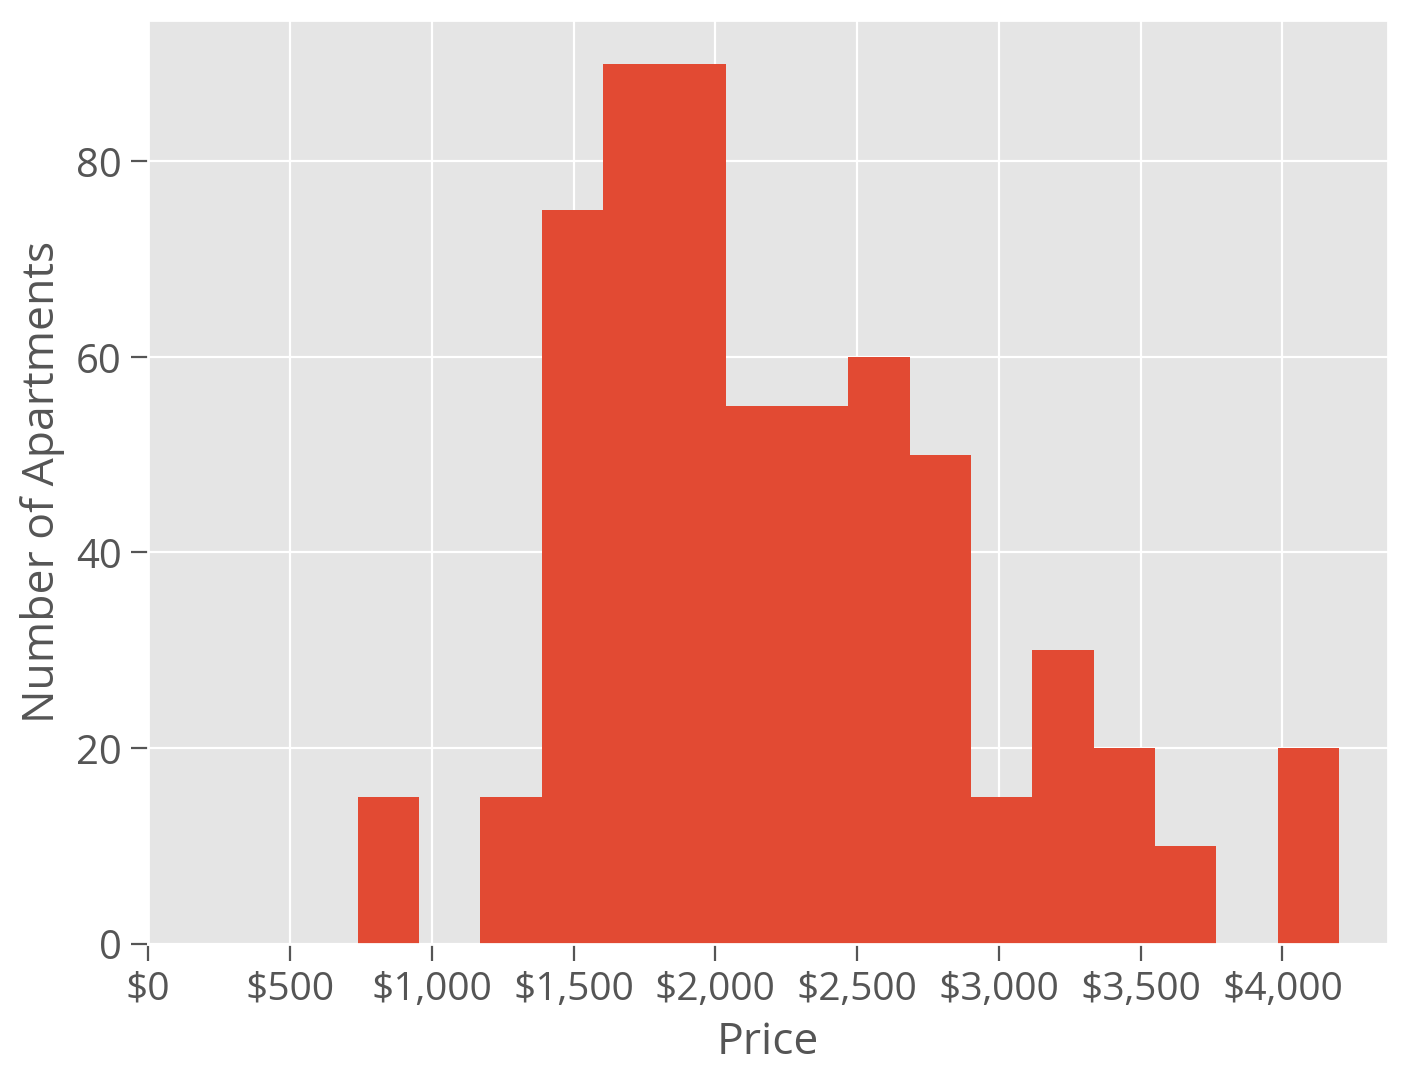

In [55]:
with plt.style.context('ggplot'):
    
    # initialize the figure
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # plot the histogram, using automatic bins
    ax.hist(results['price'], bins='auto')

    # Label the axes
    ax.set_xlabel('Price', fontsize=16)
    ax.set_ylabel('Number of Apartments', fontsize=16)
    
    # Format the ticks
    ax.set_xticks(np.arange(0, 4200, 500))
    ax.set_xticklabels([f"${x:,.0f}" for x in ax.get_xticks()], fontsize=14)
    
    plt.show();

In [56]:
# calculate price per square foot
results['price_psf'] = results['price'] / results['size']

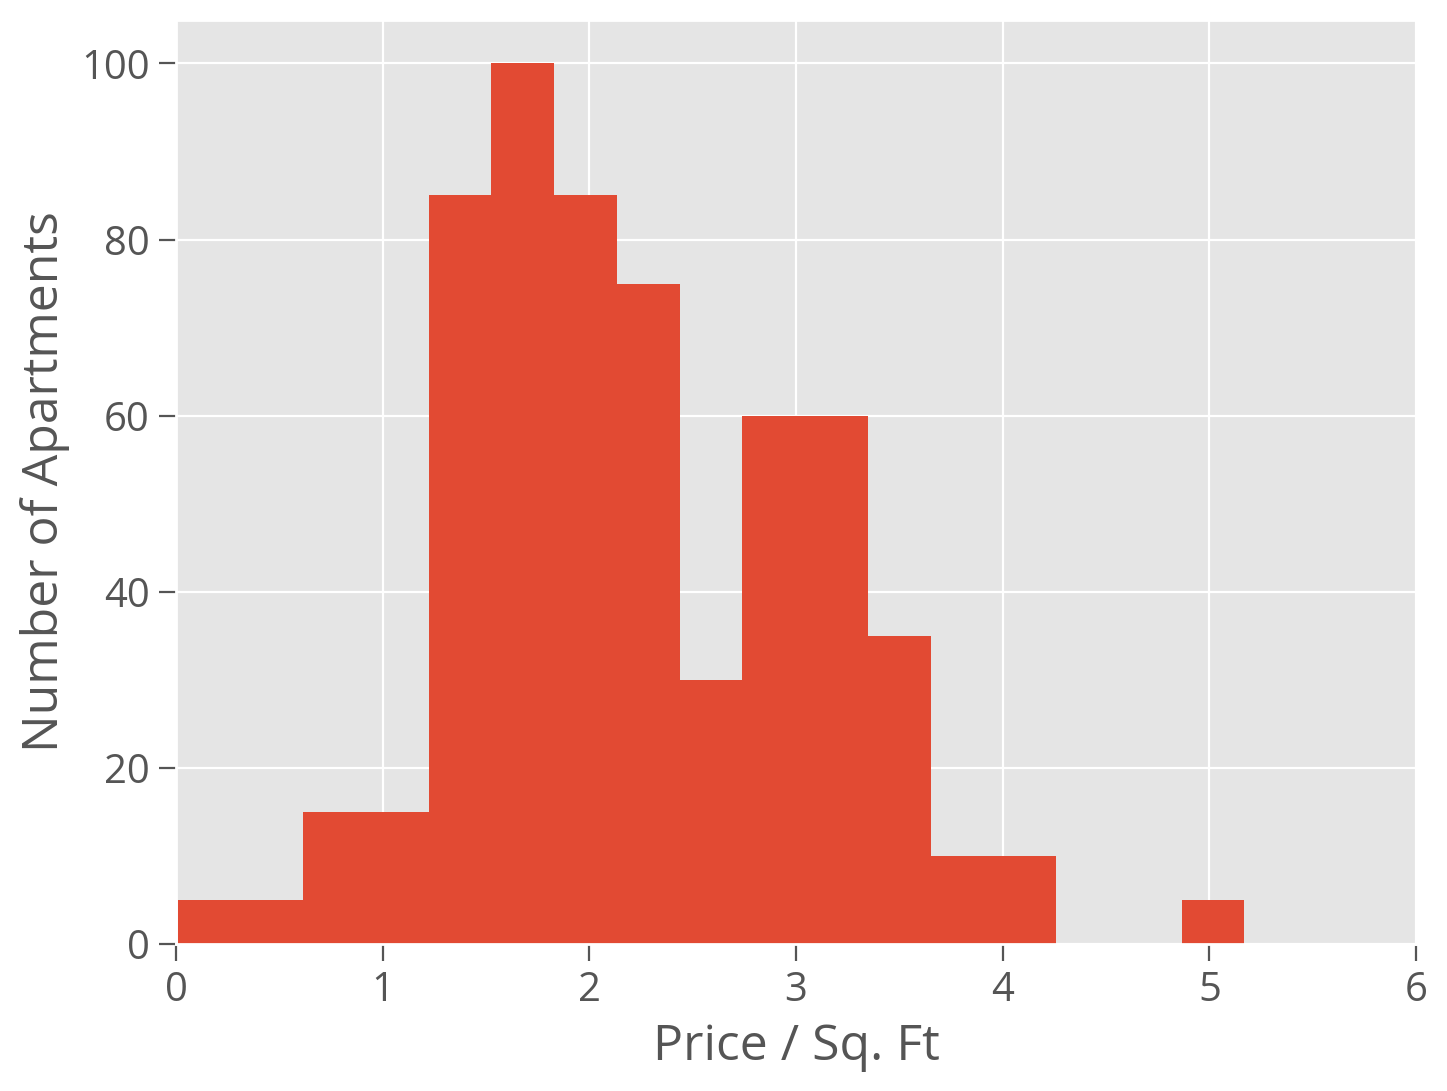

In [58]:
with plt.style.context('ggplot'):
    
    # initialize the figure
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # plot price per square foot
    ax.hist(results.loc[results['size'] > 0, 'price_psf'], bins='auto')

    # Format the axes
    ax.set_xlabel('Price / Sq. Ft', fontsize=18)
    ax.set_ylabel('Number of Apartments', fontsize=18)
    ax.set_xlim(0, 6)
    
    plt.show();

## 1.8 Comparing prices for different sizes 

Use `altair` to explore the relationship between price, size, and number of bedrooms. Make an interactive scatter plot of price (x-axis) vs. size (y-axis), with the points colored by the number of bedrooms. 

Make sure the plot is interactive (zoom-able and pan-able) and add a tooltip with all of the columns in our scraped data frame.

With this sort of plot, you can quickly see the outlier apartments in terms of size and price.

In [59]:
import altair as alt

In [60]:
len(results)

600

In [66]:
alt.Chart(results).mark_point(size=60).encode(
    x=alt.X("price:Q"),
    y=alt.Y("size:Q", scale=alt.Scale(domain=(0, 3000))),
    color="bedrooms:N",
    tooltip=["title", "price", "size", "bedrooms"],
).interactive()

alt.Chart(...)

## Part 2: Making an animated map with Datashader

In this part, you will load a "large" data set of your choice and make an animated map of the data using datashader. 

There are several good options available from Open Data Philly, but you are welcome to choose a different source, as long it meets the requirements below.

#### Deliverable
Your final result should be a GIF animating changes in the data set in time. This GIF should be submitted to your repository, and the code used to produce the GIF should be in the notebook.

#### Notes
- For best results with datashader, the dataset should be at least 500,000 rows in size. If you are having difficulty finding a data set large enough, please email me.
- The data must have a date time column, so that you can animate the data in time.
- You can use either dask or pandas to load the data. If you're data set is approaching the size of your machine's memory, you will want to use dask.
- Recommendations from Open Data Philly include: 
    - [311 Requests](https://www.opendataphilly.org/dataset/311-service-and-information-requests)
    - [Crime Incidents](https://www.opendataphilly.org/dataset/crime-incidents)
    - [L&I Code Violations](https://www.opendataphilly.org/dataset/licenses-and-inspections-violations)
    - [Real Estate Transfers](https://www.opendataphilly.org/dataset/real-estate-transfers)
- You can animate the data by the hour or by the year, e.g., parking violations by hour of day, or parking violations by year.

#### Examples
I've includes several potential examples in the assignment repository.

#### Optional
You can overlay Philadelphia city limits using geopandas. See the lecture slides for an example of how to do this.

In [69]:
import datashader as ds
import datashader.transfer_functions as tf
from datashader.colors import viridis
from datashader.utils import lnglat_to_meters as webm
import geopandas as gpd

In [70]:
# load the city limits
city_limits = gpd.read_file("data/City_Limits.geojson").to_crs(epsg=3857)

In [121]:
# Load Criminal Incident data 
# Downloaded from OpenDataPhilly
df = pd.read_csv("data/incidents_part1_part2.csv")

# convert to web mercator x and y
df['x'], df['y'] = webm(df['lng'], df['lat'])

# add an hour column
df['dispatch_date_time'] = pd.to_datetime(df['dispatch_date_time'])
df['hour'] = df['dispatch_date_time'].dt.hour

In [122]:
def create_image(df, x_range, y_range, w=750, h=750, cmap=viridis):
    
    # create the canvas
    cvs = ds.Canvas(plot_width=w, plot_height=h, x_range=x_range, y_range=y_range)
    
    # plot dropoff positions, coutning number of passengers
    agg = cvs.points(df, 'x', 'y')
    
    # shade
    img = tf.shade(agg, cmap=cmap, how='eq_hist', min_alpha=150)
    
    # return an PIL image
    return tf.set_background(img, "black").to_pil()

In [123]:
def convert_to_12hour(hr24):
    """
    Convert from 24 hr to 12 hr.
    """
    from datetime import datetime

    d = datetime.strptime(str(hr24), "%H")
    return d.strftime("%I %p")

In [124]:
def plot_by_hour(fig, df_all_hours, hour, title):
    """
    Plot for a particular hour
    """
    # get the x and y range from the city limits
    # extent = [xmin, ymin, xmax, ymax]
    extent = city_limits.total_bounds
    x_range = extent[0], extent[2]
    y_range = extent[1], extent[3]

    # data for this hour
    df = df_all_hours.loc[df_all_hours['hour']==hour]

    # create the image for this hour
    img = create_image(df, x_range, y_range)

    # plot the image on a matplotlib axes
    plt.clf()
    ax = fig.gca()
    ax.imshow(img, extent=[x_range[0], x_range[1], y_range[0], y_range[1]])
    ax.axis("off")

    # add city limits
    city_limits.plot(ax=ax, facecolor="none", edgecolor="white", linewidth=2)

    # add a text label for the hour
    t = convert_to_12hour(hour)
    ax.text(0.05, 0.9, t, color="white", fontsize=40, ha="left", transform=ax.transAxes)

    # add the title
    fig.text(0.72, 0.2, title, fontsize=35, color="white", ha="center")

    # format the axes
    ax.set_axis_off()
    ax.set_aspect("equal")
    fig.subplots_adjust(left=0, right=1, top=1, bottom=0)
    fig.tight_layout()

    # draw the figure and return the image
    fig.canvas.draw()
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype="uint8")
    image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))

    return image

In [125]:
import imageio

In [126]:
title = "Philadelphia\nCriminal Incidents\nSince 2006"
filename = 'crime_incidents.gif'

In [127]:
# create a figure
fig, ax = plt.subplots(figsize=(10,10), facecolor='black')

# get the selection
hours = list(range(24))
fps = 1 

# make the images for each hour
images = []
for hour in hours:
    image = plot_by_hour(fig, df, hour, title)
    images.append(image)
    
# combine the images into a GIF
imageio.mimsave(filename, images, fps=fps);